In [1]:
import os
import collections
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import cv2
import json

from sklearn import preprocessing 


import xml.etree.ElementTree as ET

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SequentialSampler

In [2]:
BASE_PATH = "dectionDataset/train/01"
IMG_PATH = os.path.join(BASE_PATH, "Images")
ABNORM_IMG_PATH = os.path.join(BASE_PATH, "abnormImagesLabel")
JSON_PATH= os.path.join(BASE_PATH, "TRAIN_objects.json")

In [3]:
class thirdDataset(object):
    def __init__(self,json_file):
        self.json_file = json_file
        # 读取json文件
        with open(os.path.join(JSON_PATH),'r') as load_f:
            load_dict = json.load(load_f)
        self.labels = []
        self.boxes = []
        self.image_id = []
        self.img_path = []
        for item in load_dict:
            # print(item['labels'])
            # print(item['boxes'])
            # print(item['name'])
            # print('--------------')
            self.labels.extend(item['labels'])
            self.boxes.extend(item['boxes'])
            self.image_id.extend([item['name']]*len(item['boxes']))
            self.img_path.extend([os.path.join(IMG_PATH, item['name']+'.jpg')]*len(item['boxes']))
            
    def to_df(self):
        a = {"image_id": self.image_id,
             "labels": self.labels,
             "boxes": self.boxes,
             "img_path":self.img_path}
        df = pd.DataFrame.from_dict(a, orient='index')
        df = df.transpose()
        return df

In [4]:
dataset=thirdDataset(JSON_PATH)
df=dataset.to_df()
df.head()

,image_id,labels,boxes,img_path
0,01_0001,air-hole,"[60, 241, 89, 257]",dectionDataset/train/01\Images\01_0001.jpg
1,01_0002,air-hole,"[702, 725, 721, 742]",dectionDataset/train/01\Images\01_0002.jpg
2,01_0002,hollow-bead,"[311, 372, 372, 418]",dectionDataset/train/01\Images\01_0002.jpg
3,01_0002,air-hole,"[376, 429, 398, 447]",dectionDataset/train/01\Images\01_0002.jpg
4,01_0002,air-hole,"[111, 175, 127, 190]",dectionDataset/train/01\Images\01_0002.jpg


In [5]:
# check values for per class
df['labels'].value_counts()

air-hole          23
slag-inclusion     2
hollow-bead        1
Name: labels, dtype: int64

In [6]:
# classes need to be in int form so we use LabelEncoder for this task
enc = preprocessing.LabelEncoder()
df['labels_num'] = enc.fit_transform(df['labels'])
df['labels_num'] = np.stack(df['labels_num'][i]+1 for i in range(len(df['labels_num']))) 

D:\Anaconda3-5.3.1\envs\python37\lib\site-packages\IPython\core\interactiveshell.py:3263: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [7]:
classes = df[['labels','labels_num']].value_counts()
classes

labels          labels_num
air-hole        1             23
slag-inclusion  3              2
hollow-bead     2              1
dtype: int64

In [8]:
# make dictionary for class objects so we can call objects by their keys.
classes= {1:'air-hole',2:'hollow-bead',3:'slag-inclusion'}

In [9]:
# bounding box coordinates point need to be in separate columns
df['xmin'] = -1
df['ymin'] = -1
df['xmax'] = -1
df['ymax'] = -1

df[['xmin','ymin','xmax','ymax']]=np.stack(df['boxes'][i] for i in range(len(df['boxes'])))

df.drop(columns=['boxes'], inplace=True)
df['xmin'] = df['xmin'].astype(np.float)
df['ymin'] = df['ymin'].astype(np.float)
df['xmax'] = df['xmax'].astype(np.float)
df['ymax'] = df['ymax'].astype(np.float)

In [10]:
df.head()

,image_id,labels,img_path,labels_num,xmin,ymin,xmax,ymax
0,01_0001,air-hole,dectionDataset/train/01\Images\01_0001.jpg,1,60.0,241.0,89.0,257.0
1,01_0002,air-hole,dectionDataset/train/01\Images\01_0002.jpg,1,702.0,725.0,721.0,742.0
2,01_0002,hollow-bead,dectionDataset/train/01\Images\01_0002.jpg,2,311.0,372.0,372.0,418.0
3,01_0002,air-hole,dectionDataset/train/01\Images\01_0002.jpg,1,376.0,429.0,398.0,447.0
4,01_0002,air-hole,dectionDataset/train/01\Images\01_0002.jpg,1,111.0,175.0,127.0,190.0


In [11]:
df['labels_num'].unique()

array([1, 2, 3])

In [12]:
len(df['image_id'].unique())

10

In [13]:
image_ids = df['image_id'].unique()
valid_ids = image_ids[-3:]
train_ids = image_ids[:-3]
len(train_ids)

7

In [14]:
valid_df = df[df['image_id'].isin(valid_ids)]
train_df = df[df['image_id'].isin(train_ids)]
valid_df.shape, train_df.shape

((6, 8), (20, 8))

In [15]:
class officialDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        
        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
    
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        # 读取pd的一条或多条记录
        records = self.df[self.df['image_id'] == image_id]
        # 根据id读入图片
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        # 转换图片的颜色空间
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        # 归一化图片
        image /= 255.0
        rows, cols = image.shape[:2]
        
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        
       
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        label = records['labels_num'].values
        labels = torch.as_tensor(label, dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1,0)
            
            return image, target
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [16]:
def get_transform_train():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2(p=1.0)
    ], bbox_params={'format':'pascal_voc', 'label_fields': ['labels']})

def get_transform_valid():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format':'pascal_voc', 'label_fields':['labels']})

In [17]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = officialDataset(train_df, IMG_PATH, get_transform_train())
valid_dataset = officialDataset(valid_df, IMG_PATH, get_transform_valid())

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


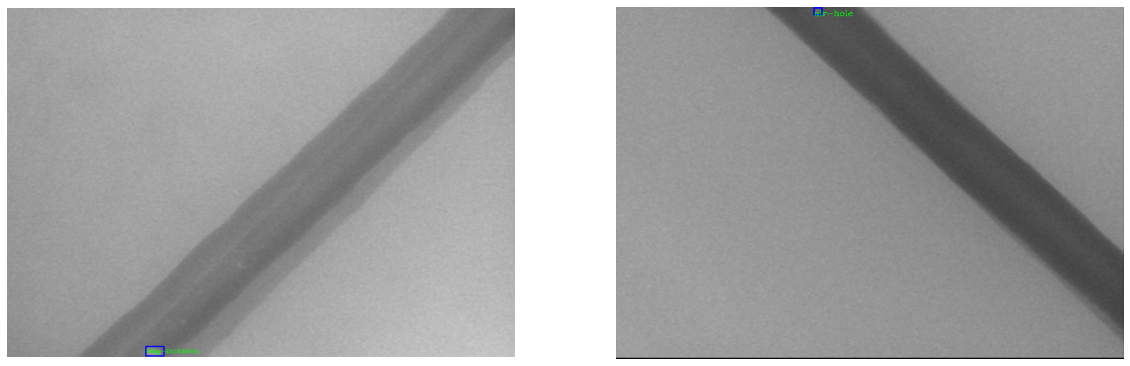

In [19]:
images, targets = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
# print(images)
# print(targets)
# print('-----------------')

plt.figure(figsize=(20,20))
for i, (image, target) in enumerate(zip(images, targets)):
    plt.subplot(2,2, i+1)
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy()
    names = targets[i]['labels'].cpu().numpy().astype(np.int64)
    # print(sample)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 0, 220), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]+15),cv2.FONT_HERSHEY_COMPLEX ,0.5,(0,220,0),1,cv2.LINE_AA)  

    plt.axis('off')
    plt.imshow(sample)

In [20]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [21]:
num_classes = 4

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [22]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [23]:
from engine import train_one_epoch, evaluate
import utils

In [24]:
# let's train it for 2 epochs
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, valid_data_loader, device=device)

D:\Anaconda3-5.3.1\envs\python37\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [0/4]  eta: 0:00:52  lr: 0.001670  loss: 1.5279 (1.5279)  loss_classifier: 1.3912 (1.3912)  loss_box_reg: 0.0638 (0.0638)  loss_objectness: 0.0713 (0.0713)  loss_rpn_box_reg: 0.0017 (0.0017)  time: 13.1768  data: 0.0791  max mem: 2310
Epoch: [0]  [3/4]  eta: 0:00:04  lr: 0.005000  loss: 1.5279 (1.8745)  loss_classifier: 0.8928 (1.0937)  loss_box_reg: 0.0638 (0.1672)  loss_objectness: 0.0713 (0.5302)  loss_rpn_box_reg: 0.0204 (0.0834)  time: 4.2945  data: 0.0805  max mem: 2417
Epoch: [0] Total time: 0:00:17 (4.3142 s / it)
creating index...
index created!
Test:  [0/2]  eta: 0:00:01  model_time: 0.7776 (0.7776)  evaluator_time: 0.0450 (0.0450)  time: 0.9165  data: 0.0788  max mem: 2417
Test:  [1/2]  eta: 0:00:00  model_time: 0.3122 (0.5449)  evaluator_time: 0.0040 (0.0245)  time: 0.6248  data: 0.0469  max mem: 2417
Test: Total time: 0:00:01 (0.6253 s / it)
Averaged stats: model_time: 0.3122 (0.5449)  evaluator_time: 0.0040 (0.0245)
Accumulating evaluation results...
DONE (t=0

In [25]:
torch.save(model.state_dict(), 'faster_rcnn_state.pth')

In [26]:
# load  a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

WEIGHTS_FILE = "./faster_rcnn_state.pth"

num_classes = 4

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the traines weights
model.load_state_dict(torch.load(WEIGHTS_FILE))

model = model.to(device)

In [27]:
def obj_detector(img):
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)


    img /= 255.0
    img = torch.from_numpy(img)
    img = img.unsqueeze(0)
    img = img.permute(0,3,1,2)
    
    model.eval()

    #阈值
    detection_threshold = 0.5
    
    img = list(im.to(device) for im in img)
    output = model(img)

    for i , im in enumerate(img):
        boxes = output[i]['boxes'].data.cpu().numpy()
        scores = output[i]['scores'].data.cpu().numpy()
        labels = output[i]['labels'].data.cpu().numpy()

        labels = labels[scores >= detection_threshold]
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
    
    sample = img[0].permute(1,2,0).cpu().numpy()
    sample = np.array(sample)
    boxes = output[0]['boxes'].data.cpu().numpy()
    name = output[0]['labels'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    names = name.tolist()
    
    return names, boxes, sample

['dectionDataset/test/01\\01_0001.jpg', 'dectionDataset/test/01\\01_0002.jpg', 'dectionDataset/test/01\\01_0003.jpg', 'dectionDataset/test/01\\01_0004.jpg', 'dectionDataset/test/01\\01_0005.jpg', 'dectionDataset/test/01\\01_0006.jpg', 'dectionDataset/test/01\\01_0007.jpg', 'dectionDataset/test/01\\01_0008.jpg', 'dectionDataset/test/01\\01_0009.jpg', 'dectionDataset/test/01\\01_0010.jpg', 'dectionDataset/test/01\\01_0011.jpg', 'dectionDataset/test/01\\01_0012.jpg', 'dectionDataset/test/01\\01_0013.jpg', 'dectionDataset/test/01\\01_0014.jpg', 'dectionDataset/test/01\\01_0015.jpg', 'dectionDataset/test/01\\01_0016.jpg', 'dectionDataset/test/01\\01_0017.jpg', 'dectionDataset/test/01\\01_0018.jpg', 'dectionDataset/test/01\\01_0019.jpg', 'dectionDataset/test/01\\01_0020.jpg']
labels: [2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 1, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 

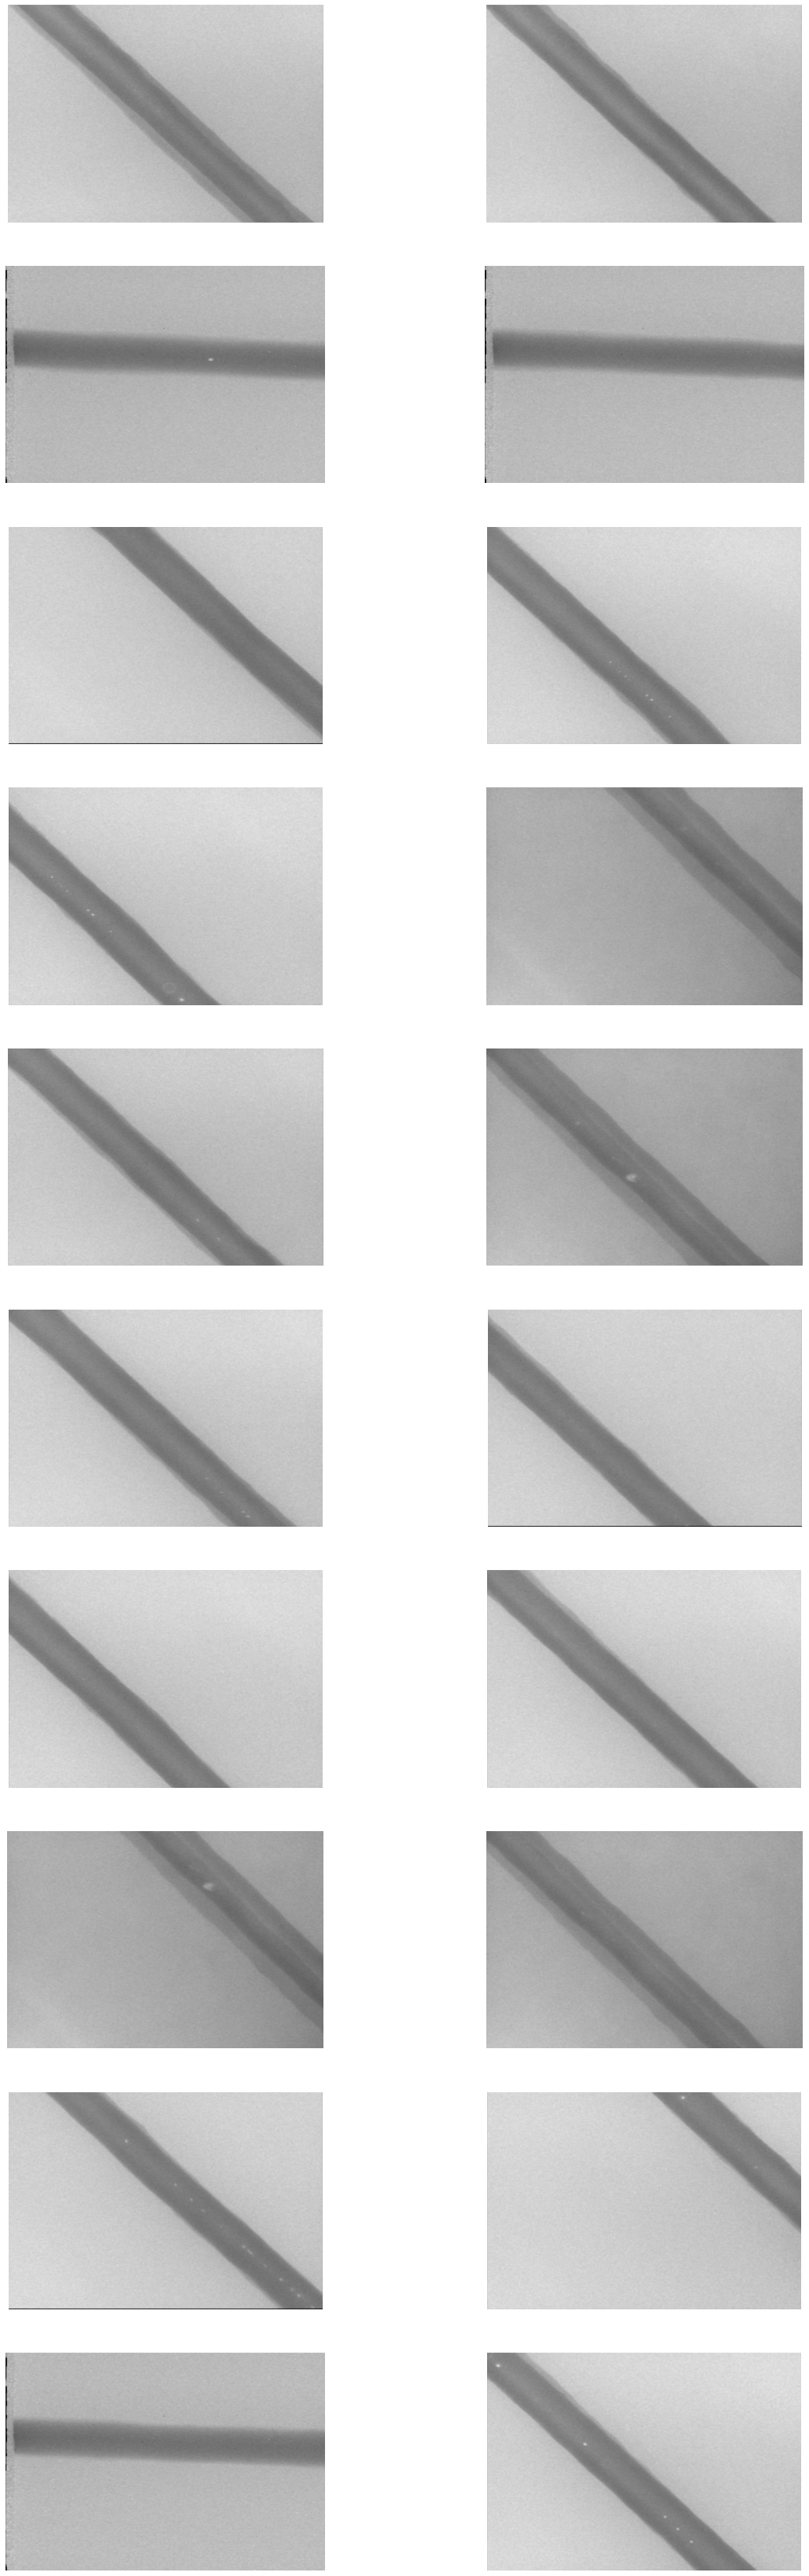

In [28]:
# 我把test的图片也提取出来放不同的文件夹（01表示第一个类的测试集图片）
pred_path = "dectionDataset/test/01"
pred_files = [os.path.join(pred_path,f) for f in os.listdir(pred_path)]
print(pred_files)

plt.figure(figsize=(20,60))
for i, images in enumerate(pred_files):
    if i > 19:
        break
    plt.subplot(10,2,i+1)
    names,boxes,sample = obj_detector(images)
    print('labels:',names)
    print('boxes:',boxes)
    # print('sample:',sample)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 220, 0), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]-5),cv2.FONT_HERSHEY_COMPLEX ,0.7,(220,0,0),1,cv2.LINE_AA)  

    plt.axis('off')
    plt.imshow(sample)